In [22]:
%pip install optuna
%pip install imblearn
%pip install matplotlib
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Library Import

In [23]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold
import optuna
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt


### Data Load

In [24]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df_origin: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [25]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_NETWORK") and f.endswith(".csv")
]

additional_files = [
    "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv",
    "HOURLY_MARKET-DATA_FUNDING-RATES_BINANCE.csv",
    "HOURLY_MARKET-DATA_LIQUIDATIONS_BINANCE_ALL_SYMBOL.csv",
    "HOURLY_MARKET-DATA_OPEN-INTEREST_BINANCE_ALL_SYMBOL.csv",
    "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_BINANCE.csv"
]

file_names.extend(additional_files)

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df_origin = df_origin.merge(_df, on="ID", how="left")

100%|██████████| 19/19 [00:00<00:00, 96.35it/s]


### Feature engineering

In [26]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_binance_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_binance_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_binance_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_binance_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_binance_taker_sell_volume": "sell_volume",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
}
df = df_origin[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 18)

In [27]:
# 새로운 feature를 생성하고 기존의 feature 제거 or 실험 결과로 제외할 feature를 할당
items_to_check = ["supply_total", "blockreward",  "coinbase_premium_index", "funding_rates", "open_interest"]

#기존에 존재하거나 새로 만들었지만 제외한것
'''
"buy_ratio", "sell_ratio","long_liquidations", "short_liquidations", "long_liquidations_usd", "short_liquidations_usd", 
liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
volume_imbalance=(df["buy_volume"] - df["sell_volume"])/(df["buy_volume"] + df["sell_volume"]+ 1e-8),
'''
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df_train = df.assign(
    liquidation_usd_imbalance=(df['long_liquidations_usd'] - df['short_liquidations_usd']) / (df['long_liquidations_usd'] + df['short_liquidations_usd'] + 1e-8),
    liquidation_imbalance=(df['long_liquidations'] - df['short_liquidations']) / (df['long_liquidations'] + df['short_liquidations'] + 1e-8),
)

df_train = df_train.drop(items_to_check, axis=1)

# category, continuous 열을 따로 할당해둠
# 증강 및 표준화 등의 전처리를 할 때 구분을 위해 사용
#category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in (["ID", "target", "_type"] + items_to_check)] + [
    "liquidation_usd_imbalance",
    "liquidation_imbalance",
]

In [28]:
# Create rolling averages for all continuous columns
for col in conti_cols:
    df_train[f'{col}_rolling_5'] = df_train[col].rolling(window=5).mean()
    '''df_train[f'{col}_rolling_10'] = df_train[col].rolling(window=10).mean()
    df_train[f'{col}_rolling_20'] = df_train[col].rolling(window=20).mean()
    df_train[f'{col}_rolling_60'] = df_train[col].rolling(window=60).mean()
    df_train[f'{col}_rolling_100'] = df_train[col].rolling(window=120).mean()
    #df_train[f'{col}_rolling_200'] = df_train[col].rolling(window=200).mean()'''

In [29]:
def shift_feature(
    df_train: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df_train[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# shift된 피처를 conti_cols에 추가
def update_conti_cols_with_shifts(conti_cols: List[str], intervals: List[int]) -> List[str]:
    shifted_cols = [f"{conti_col}_{interval}" for conti_col in conti_cols for interval in intervals]
    return conti_cols + shifted_cols

# 최대 8시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df_train=df_train, conti_cols=conti_cols, intervals=[_ for _ in range(1, 9)]
)

# conti_cols에 shift된 피처들의 이름 추가
conti_cols = update_conti_cols_with_shifts(conti_cols, intervals=[_ for _ in range(1, 9)])

print(f"Updated conti_cols: {conti_cols}")

Updated conti_cols: ['coinbase_premium_gap', 'long_liquidations', 'long_liquidations_usd', 'short_liquidations', 'short_liquidations_usd', 'buy_ratio', 'buy_volume', 'sell_ratio', 'sell_volume', 'blockreward_usd', 'liquidation_usd_imbalance', 'liquidation_imbalance', 'coinbase_premium_gap_1', 'coinbase_premium_gap_2', 'coinbase_premium_gap_3', 'coinbase_premium_gap_4', 'coinbase_premium_gap_5', 'coinbase_premium_gap_6', 'coinbase_premium_gap_7', 'coinbase_premium_gap_8', 'long_liquidations_1', 'long_liquidations_2', 'long_liquidations_3', 'long_liquidations_4', 'long_liquidations_5', 'long_liquidations_6', 'long_liquidations_7', 'long_liquidations_8', 'long_liquidations_usd_1', 'long_liquidations_usd_2', 'long_liquidations_usd_3', 'long_liquidations_usd_4', 'long_liquidations_usd_5', 'long_liquidations_usd_6', 'long_liquidations_usd_7', 'long_liquidations_usd_8', 'short_liquidations_1', 'short_liquidations_2', 'short_liquidations_3', 'short_liquidations_4', 'short_liquidations_5', 'sho

In [30]:
# concat 하여 df 에 할당
df_train = pd.concat([df_train, pd.concat(shift_list, axis=1)], axis=1)

In [31]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df_train["target"]
df_train = df_train.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df_train.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df_train.loc[df["_type"]=="test"].drop(columns=["_type"])

In [32]:
train_df

,ID,target,coinbase_premium_gap,long_liquidations,long_liquidations_usd,short_liquidations,short_liquidations_usd,buy_ratio,buy_volume,sell_ratio,...,liquidation_usd_imbalance_7,liquidation_usd_imbalance_8,liquidation_imbalance_1,liquidation_imbalance_2,liquidation_imbalance_3,liquidation_imbalance_4,liquidation_imbalance_5,liquidation_imbalance_6,liquidation_imbalance_7,liquidation_imbalance_8
0,2023-01-01 00:00:00,2.0,-9.86,0.012000,1.975161e+02,0.000,0.00000,0.471901,4.151979e+07,0.528099,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
1,2023-01-01 01:00:00,1.0,-8.78,0.000000,0.000000e+00,0.712,11833.56104,0.601135,3.177677e+07,0.398865,...,-999.000000,-999.000000,0.999999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
2,2023-01-01 02:00:00,1.0,-9.59,0.000000,0.000000e+00,0.000,0.00000,0.491115,1.907553e+07,0.508885,...,-999.000000,-999.000000,-1.000000,0.999999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
3,2023-01-01 03:00:00,1.0,-9.74,0.593000,9.754769e+03,0.000,0.00000,0.447529,2.349391e+07,0.552471,...,-999.000000,-999.000000,0.000000,-1.000000,0.999999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
4,2023-01-01 04:00:00,2.0,-10.14,0.361000,5.944437e+03,0.000,0.00000,0.502389,2.614367e+07,0.497611,...,-999.000000,-999.000000,1.000000,0.000000,-1.000000,0.999999,-999.000000,-999.000000,-999.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,1.0,-27.10,0.163000,6.924677e+03,0.014,600.62560,0.523165,8.796743e+07,0.476835,...,0.578943,0.972307,-0.956721,-0.838217,-0.973777,0.327364,-0.112583,0.118297,0.581729,0.972556
8756,2023-12-31 20:00:00,1.0,-24.73,7.347896,3.119033e+05,6.532,279693.16923,0.521637,1.050842e+08,0.478363,...,0.114233,0.578943,0.841808,-0.956721,-0.838217,-0.973777,0.327364,-0.112583,0.118297,0.581729
8757,2023-12-31 21:00:00,0.0,-28.48,0.122000,5.201684e+03,1.211,51776.92115,0.517185,8.363956e+07,0.482815,...,-0.116267,0.114233,0.058783,0.841808,-0.956721,-0.838217,-0.973777,0.327364,-0.112583,0.118297
8758,2023-12-31 22:00:00,2.0,-9.08,37.213441,1.573892e+06,3.496,148758.33579,0.416486,2.092672e+08,0.583514,...,0.322335,-0.116267,-0.816954,0.058783,0.841808,-0.956721,-0.838217,-0.973777,0.327364,-0.112583


## Model Training

### data set, params 선언

In [33]:
x_train = train_df.drop(["target", "ID"], axis=1)
y_train = train_df["target"].astype(int)

In [34]:
x_train.shape

(8760, 120)

### lgb

In [35]:
params = {
    "boosting_type": "dart",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "learning_rate": 0.005,
    "min_data_in_leaf": 70,
    "random_state": 42,
    "n_estimators": 500,
    "num_leaves": 30,
}

In [36]:
# 증강을 사용할 경우 성능 저하
# RobustScaler를 이용한 정규화를 사용할 경우 성능 향상
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb

# KFold 설정
n_splits = 5  # 폴드 수 설정
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 전체 예측값을 담을 리스트
y_valid_preds = np.zeros((x_train.shape[0], 4))  # 전체 데이터의 예측값 저장 (클래스 개수는 4)

# 모델들을 저장할 리스트 (각 폴드의 모델을 저장)
models = []

# 정규화 스케일러 초기화
scaler = RobustScaler()

# 10 epoch마다 진행도를 출력하는 콜백 함수
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            print(f'Iteration {env.iteration + 1}, Train Logloss: {env.evaluation_result_list[0][2]:.4f}, Valid Logloss: {env.evaluation_result_list[1][2]:.4f}')
    return callback
# 교차 검증
for fold, (train_idx, valid_idx) in enumerate(kf.split(x_train, y_train)):
    print(f"Training fold {fold+1}/{n_splits}")
    
    # 훈련 세트와 검증 세트 나누기
    X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
    Y_tr, Y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # 정규화 적용 (훈련 데이터와 검증 데이터에 RobustScaler 적용)
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)
    
    # lgb dataset
    train_data = lgb.Dataset(X_tr, label=Y_tr)
    valid_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        callbacks=[print_evaluation(10)]  # 수정된 콜백 함수 사용
    )

    
    # 모델 저장
    models.append(lgb_model)
    
    # 검증 세트 예측 (각 폴드마다 예측 결과를 저장)
    y_valid_preds[valid_idx] = lgb_model.predict(X_val)

# 예측값의 클래스 결정 (argmax로 가장 높은 확률의 클래스를 선택)
y_valid_pred_class = np.argmax(y_valid_preds, axis=1)

# score check
accuracy = accuracy_score(y_train, y_valid_pred_class)  # 전체 y_train과 비교
auroc = roc_auc_score(y_train, y_valid_preds, multi_class="ovr")  # 전체 y_train과 비교

print(f"Final Accuracy: {accuracy}, AUROC: {auroc}")

/Users/hyeonjin/Desktop/btc_prediction/code/.venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 120
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904658
[LightGBM] [Info] Start training from score -0.870004
[LightGBM] [Info] Start training from score -2.387109
Iteration 10, Train Logloss: 1.1500, Valid Logloss: 1.1561
Iteration 20, Train Logloss: 1.1445, Valid Logloss: 1.1545
Iteration 30, Train Logloss: 1.1668, Valid Logloss: 1.1780
Iteration 40, Train Logloss: 1.1781, Valid Logloss: 1.1926
Iteration 50, Train Logloss: 1.1747, Valid Logloss: 1.1904
Iteration 60, Train Logloss: 1.1706, Valid Logloss: 1.1882
Iteration 70, Train Logloss: 1.1950, Valid Logloss: 1.2131
Iteration 80, Train Logloss: 1.1918, Valid Logloss: 1.2110
Iter

/Users/hyeonjin/Desktop/btc_prediction/code/.venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Iteration 10, Train Logloss: 1.1500, Valid Logloss: 1.1563
Iteration 20, Train Logloss: 1.1444, Valid Logloss: 1.1548
Iteration 30, Train Logloss: 1.1668, Valid Logloss: 1.1781
Iteration 40, Train Logloss: 1.1780, Valid Logloss: 1.1928
Iteration 50, Train Logloss: 1.1746, Valid Logloss: 1.1909
Iteration 60, Train Logloss: 1.1706, Valid Logloss: 1.1888
Iteration 70, Train Logloss: 1.1950, Valid Logloss: 1.2138
Iteration 80, Train Logloss: 1.1919, Valid Logloss: 1.2119
Iteration 90, Train Logloss: 1.1897, Valid Logloss: 1.2104
Iteration 100, Train Logloss: 1.1843, Valid Logloss: 1.2074
Iteration 110, Train Logloss: 1.1939, Valid Logloss: 1.2171
Iteration 120, Train Logloss: 1.1934, Valid Logloss: 1.2166
Iteration 130, Train Logloss: 1.2043, Valid Logloss: 1.2277
Iteration 140, Train Logloss: 1.2018, Valid Logloss: 1.2261
Iteration 150, Train Logloss: 1.1938, Valid Logloss: 1.2214
Iteration 160, Train Logloss: 1.1974, Valid Logloss: 1.2233
Iteration 170, Train Logloss: 1.2022, Valid Loglo

/Users/hyeonjin/Desktop/btc_prediction/code/.venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Iteration 10, Train Logloss: 1.1499, Valid Logloss: 1.1563
Iteration 20, Train Logloss: 1.1443, Valid Logloss: 1.1549
Iteration 30, Train Logloss: 1.1666, Valid Logloss: 1.1785
Iteration 40, Train Logloss: 1.1777, Valid Logloss: 1.1934
Iteration 50, Train Logloss: 1.1742, Valid Logloss: 1.1915
Iteration 60, Train Logloss: 1.1701, Valid Logloss: 1.1896
Iteration 70, Train Logloss: 1.1945, Valid Logloss: 1.2147
Iteration 80, Train Logloss: 1.1914, Valid Logloss: 1.2128
Iteration 90, Train Logloss: 1.1891, Valid Logloss: 1.2114
Iteration 100, Train Logloss: 1.1837, Valid Logloss: 1.2085
Iteration 110, Train Logloss: 1.1933, Valid Logloss: 1.2180
Iteration 120, Train Logloss: 1.1928, Valid Logloss: 1.2175
Iteration 130, Train Logloss: 1.2037, Valid Logloss: 1.2287
Iteration 140, Train Logloss: 1.2011, Valid Logloss: 1.2272
Iteration 150, Train Logloss: 1.1930, Valid Logloss: 1.2226
Iteration 160, Train Logloss: 1.1966, Valid Logloss: 1.2245
Iteration 170, Train Logloss: 1.2014, Valid Loglo

/Users/hyeonjin/Desktop/btc_prediction/code/.venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Iteration 10, Train Logloss: 1.1498, Valid Logloss: 1.1558
Iteration 20, Train Logloss: 1.1441, Valid Logloss: 1.1541
Iteration 30, Train Logloss: 1.1664, Valid Logloss: 1.1776
Iteration 40, Train Logloss: 1.1776, Valid Logloss: 1.1925
Iteration 50, Train Logloss: 1.1741, Valid Logloss: 1.1907
Iteration 60, Train Logloss: 1.1699, Valid Logloss: 1.1888
Iteration 70, Train Logloss: 1.1943, Valid Logloss: 1.2139
Iteration 80, Train Logloss: 1.1912, Valid Logloss: 1.2121
Iteration 90, Train Logloss: 1.1890, Valid Logloss: 1.2108
Iteration 100, Train Logloss: 1.1835, Valid Logloss: 1.2080
Iteration 110, Train Logloss: 1.1931, Valid Logloss: 1.2174
Iteration 120, Train Logloss: 1.1926, Valid Logloss: 1.2170
Iteration 130, Train Logloss: 1.2036, Valid Logloss: 1.2282
Iteration 140, Train Logloss: 1.2010, Valid Logloss: 1.2266
Iteration 150, Train Logloss: 1.1929, Valid Logloss: 1.2219
Iteration 160, Train Logloss: 1.1965, Valid Logloss: 1.2238
Iteration 170, Train Logloss: 1.2013, Valid Loglo

/Users/hyeonjin/Desktop/btc_prediction/code/.venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Iteration 10, Train Logloss: 1.1499, Valid Logloss: 1.1560
Iteration 20, Train Logloss: 1.1442, Valid Logloss: 1.1543
Iteration 30, Train Logloss: 1.1665, Valid Logloss: 1.1778
Iteration 40, Train Logloss: 1.1776, Valid Logloss: 1.1925
Iteration 50, Train Logloss: 1.1741, Valid Logloss: 1.1906
Iteration 60, Train Logloss: 1.1699, Valid Logloss: 1.1885
Iteration 70, Train Logloss: 1.1943, Valid Logloss: 1.2135
Iteration 80, Train Logloss: 1.1912, Valid Logloss: 1.2115
Iteration 90, Train Logloss: 1.1889, Valid Logloss: 1.2101
Iteration 100, Train Logloss: 1.1834, Valid Logloss: 1.2070
Iteration 110, Train Logloss: 1.1930, Valid Logloss: 1.2166
Iteration 120, Train Logloss: 1.1925, Valid Logloss: 1.2161
Iteration 130, Train Logloss: 1.2034, Valid Logloss: 1.2273
Iteration 140, Train Logloss: 1.2008, Valid Logloss: 1.2256
Iteration 150, Train Logloss: 1.1928, Valid Logloss: 1.2208
Iteration 160, Train Logloss: 1.1964, Valid Logloss: 1.2228
Iteration 170, Train Logloss: 1.2011, Valid Loglo

### Output File Save

In [37]:
# lgb predict
y_test_pred = np.zeros((test_df.shape[0], 4))  # 4는 클래스 개수 (multiclass일 경우)

# 각 폴드의 모델을 사용하여 예측
for model in models:
    y_test_pred += model.predict(test_df.drop(["target", "ID"], axis=1)) / n_splits

# 예측값의 클래스 결정 (argmax로 가장 높은 확률의 클래스를 선택)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# output file 할당후 save 
submission_df = submission_df.assign(target=y_test_pred_class)
submission_df.to_csv("output.csv", index=False)

In [38]:
submission_df["target"].value_counts()/len(submission_df)

target
2    0.666547
1    0.325931
3    0.007521
Name: count, dtype: float64

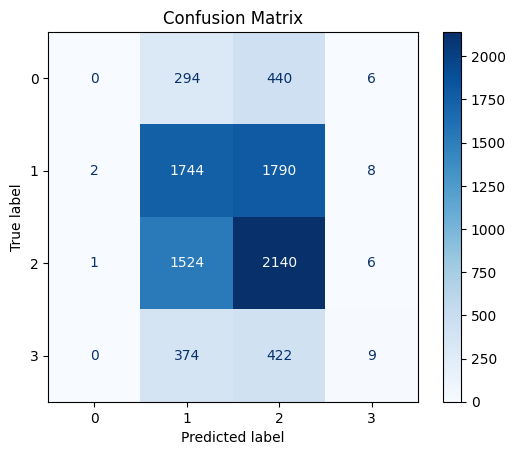

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 실제 값과 예측 값을 사용하여 혼동 행렬 생성
cm = confusion_matrix(y_train, y_valid_pred_class)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# 그래프 제목 추가
plt.title('Confusion Matrix')
plt.show()

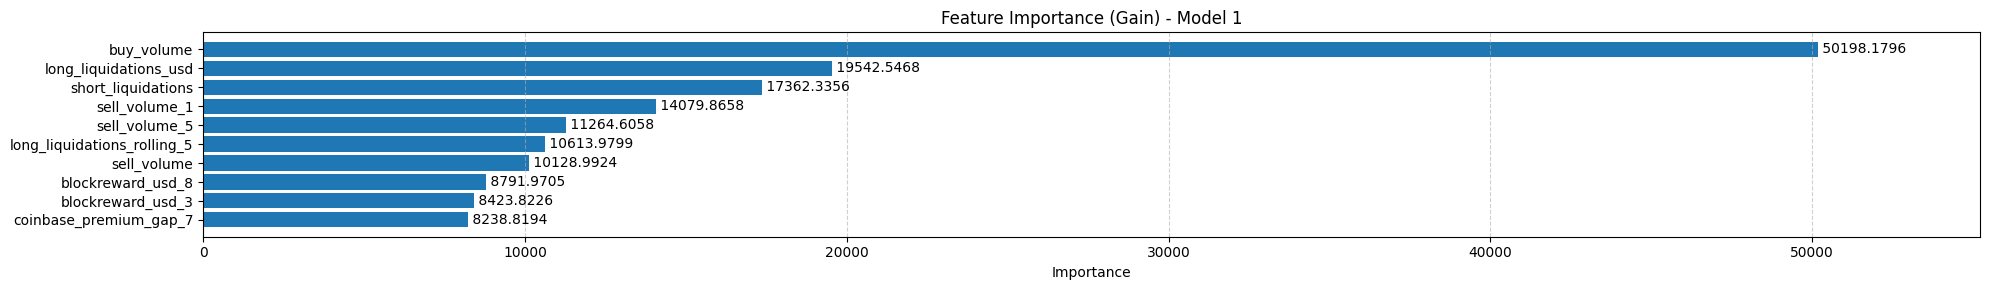

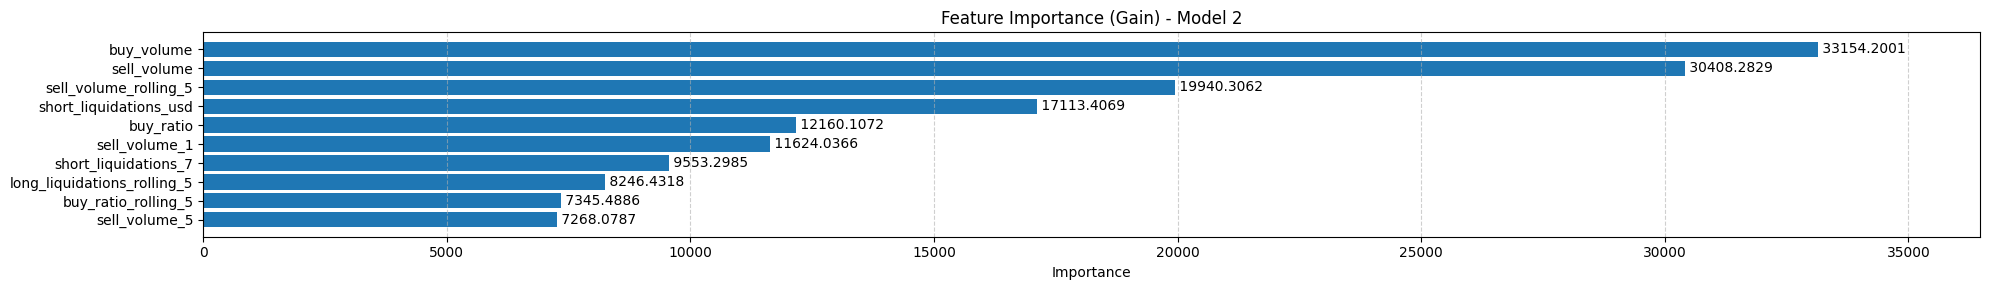

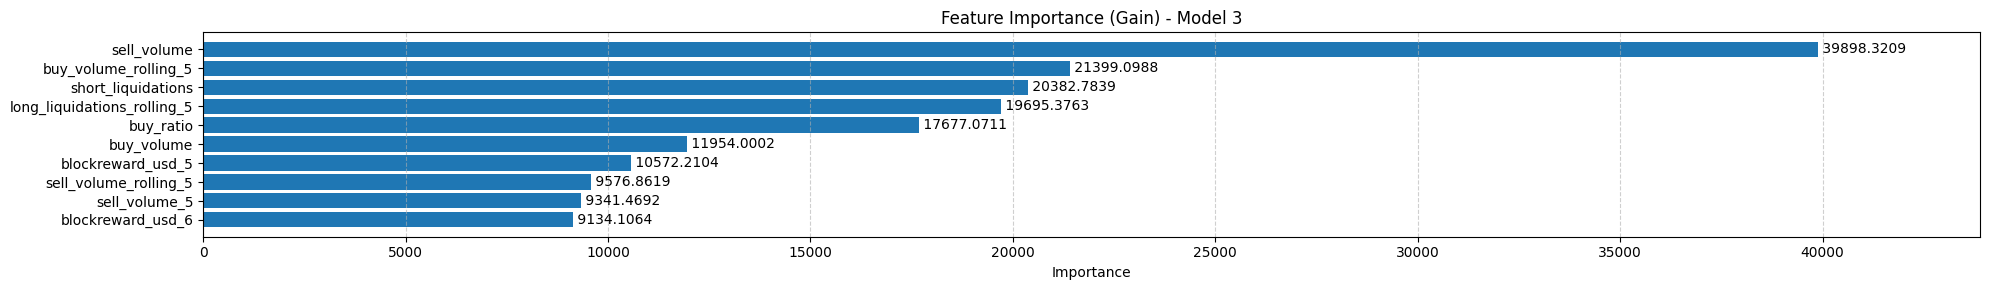

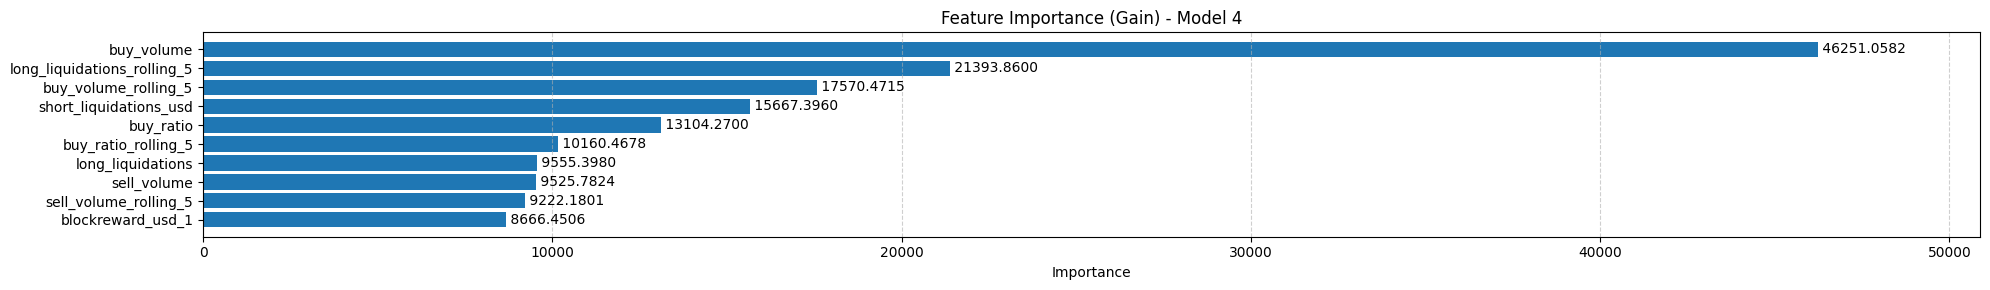

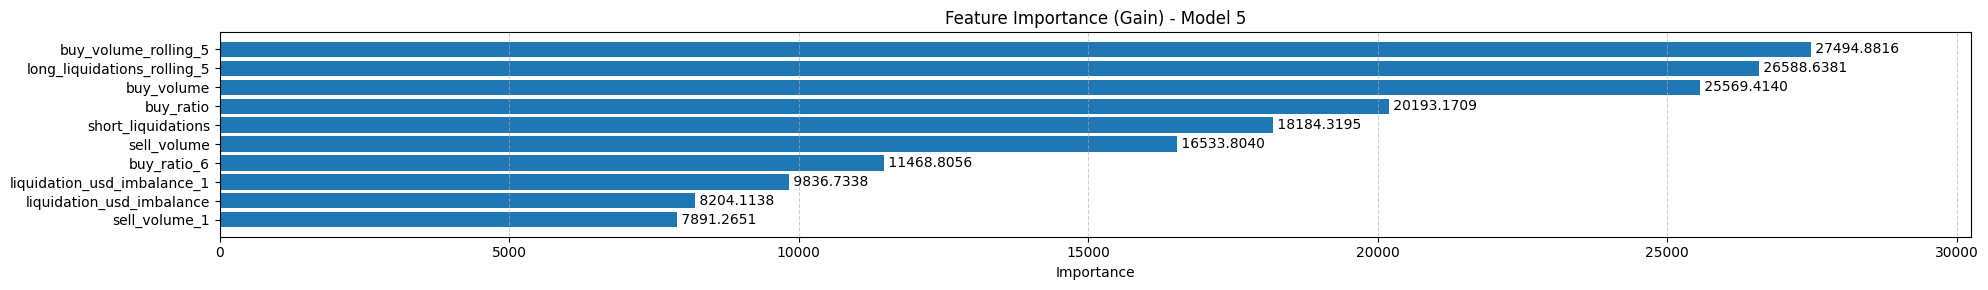

In [41]:
from lightgbm import plot_importance
import numpy as np

# 훈련 시 사용한 feature 이름 리스트
train_feature_names = x_train.columns.tolist()

# 각 모델에 대해 feature importance 플롯 생성
for i, model in enumerate(models):
    # 특성 중요도 추출
    importance = model.feature_importance(importance_type='gain')
    
    # 중요도와 feature 이름을 딕셔너리로 매핑
    feature_importance = dict(zip(train_feature_names, importance))
    
    # 중요도 순으로 정렬 (내림차순)
    sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_feature_names, sorted_importance = zip(*sorted_feature_importance[:10])  # 상위 10개만 선택

    # 그림 크기를 설정 (가로 20인치, 세로는 특성 수에 따라 조정)
    fig, ax = plt.subplots(figsize=(20, len(sorted_feature_names) * 0.3))
    
    # 수평 막대 그래프 생성
    y_pos = np.arange(len(sorted_feature_names))
    ax.barh(y_pos, sorted_importance, align='center')
    
    # y축 레이블 설정 (특성 이름)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_feature_names)
    
    # x축 레이블과 제목 설정
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance (Gain) - Model {i+1}')
    
    # 그리드 추가
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    
    # 각 막대에 수치 표시
    for i, v in enumerate(sorted_importance):
        ax.text(v, i, f' {v:.4f}', va='center')
    
    # x축 범위 설정 (여백 추가)
    ax.set_xlim(0, max(sorted_importance) * 1.1)
    
    # y축 반전 (가장 중요한 특성이 위에 오도록)
    ax.invert_yaxis()
    
    # 레이블이 잘리지 않도록 여백 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()